# Embedding an image preprocessing function in a `tf.keras` model
> Learn how to embed an image preprocessing function in a `tf.keras` model.

- toc:true
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Sayak Paul
- categories: [tf.keras, preprocessing]

In this tutorial, we are going to see how to embed a simple image preprocessing function within a _trained model_ (`tf.keras`) while exporting it for serving. This is a useful feature to have because it can help us reduce a lot of boilerplate code needed while using any model for serving purposes. With this capability, you get a lot more flexibility and modularity to your model. 

In [1]:
#hide
# Import TenosrFlow and check version
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
#hide
# Other imports
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Data loading, ~preprocessing~, and visualization

To keep things simple we will be using the FashionMNIST dataset. Note that these techniques can easily be applied to more complex models as well (with some limitation). 

> We are **not** going to preprocess the images before hand. We will let the model do it. 

In [0]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [0]:
# Class labels (don't change the order)
CLASSES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

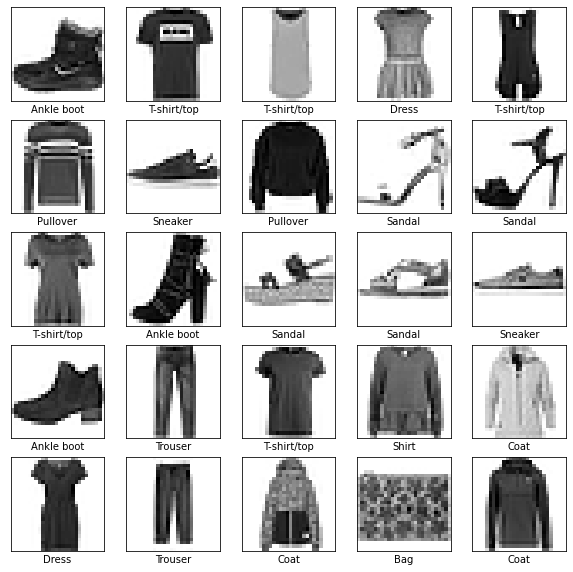

In [5]:
# Show a few examples from the train set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(CLASSES[y_train[i]])
plt.show()

## Model building and training

We are good to proceed towards building and training a neural network. We will first define a simple preprocessing function to scale the pixel values and then we will embed it into the model using a [`Lambda` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda). You can replace this anything fancy you would want. 

We will use a shallow network architecture so that we can train it quickly. 



In [0]:
# Define the preprocessing function
# We will embed it in the model later
def preprocess_image(image_pixels):
    img = image_pixels / 255
    return img

# A humble model
def get_training_model():
    # Construct the model using the Functional API
    input_layer = tf.keras.layers.Input(shape=(28, 28), name="input_layer")
    preproc_layer = tf.keras.layers.Lambda(preprocess_image, name="lambda_layer")(input_layer) # Preprocessing function
    flatten = tf.keras.layers.Flatten()(preproc_layer)
    dense_1 = tf.keras.layers.Dense(128, activation="relu")(flatten)
    dropout = tf.keras.layers.Dropout(0.2)(dense_1)
    outputs = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(dropout)

    # Create the model
    model = tf.keras.models.Model(input_layer, outputs)

    # Compile the model and return it
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
        
    return model

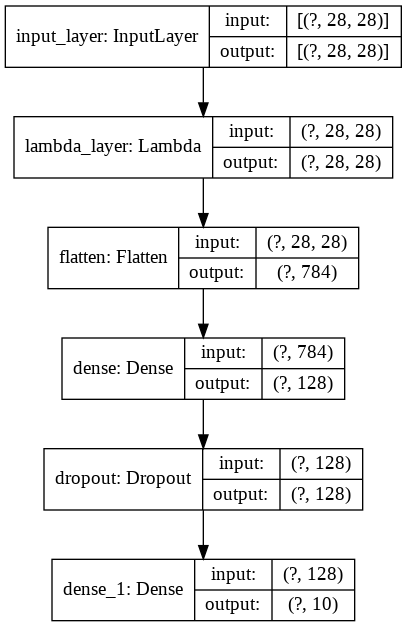

In [7]:
# Topology of the model
tf.keras.utils.plot_model(get_training_model(), show_shapes=True)

The `Lambda` layer is our preprocessing layer. 

In [8]:
# Train the model for 10 epochs
apparel_model = get_training_model()
history = apparel_model.fit(x_train, y_train, 
    validation_data=(x_test, y_test), 
    epochs=10, 
    batch_size=128)

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6004 - accuracy: 0.7937 - val_loss: 0.4682 - val_accuracy: 0.8347
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4246 - accuracy: 0.8495 - val_loss: 0.4089 - val_accuracy: 0.8521
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3795 - accuracy: 0.8642 - val_loss: 0.3928 - val_accuracy: 0.8564
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3576 - accuracy: 0.8711 - val_loss: 0.3632 - val_accuracy: 0.8687
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3407 - accuracy: 0.8762 - val_loss: 0.3593 - val_accuracy: 0.8688
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3294 - accuracy: 0.8788 - val_loss: 0.3532 - val_accuracy: 0.8721
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3165 - accuracy: 0.8846 - val_loss: 0.3609 - val_accuracy: 0.8685
Epoch 

Now that we have a trained model, we can go ahead and export it and then we will see how to use it on new images for inference. 

## Sample test image and model export

We are getting close. Now that we have a trained model here are the things we would do from here:
- Serialize a randomly selected image from the test set.  
- Export the model and parse model predictions. 

Let's go.

### Step 1: Serializing a randomly selected image from the test set

In [9]:
# Select a random image from the test set for serialization
sampe_test_img_id = np.random.choice(x_test.shape[0], 1)
sampe_test_img = x_test[sampe_test_img_id].squeeze() # Remove the batch dimension
sampe_test_img = (sampe_test_img * 255).astype("int32") # Scale back to integer

# Verify image label and shape
print("Image class: ",CLASSES[y_test[int(sampe_test_img_id)]])
print(sampe_test_img.shape)

Image class:  Ankle boot
(28, 28)


In [10]:
#hide_output
# Serialize the image
cv2.imwrite("sample_image.png", sampe_test_img)

True

Note that while writing a grayscale image, [OpenCV adds the channel dimension of 3 to it](https://stackoverflow.com/questions/18870603/in-opencv-python-why-am-i-getting-3-channel-images-from-a-grayscale-image). We will need to handle carefully. 

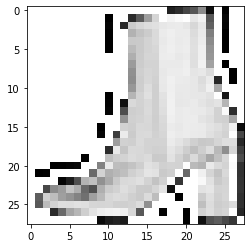

In [11]:
# Make sure the serialized image is good to go
plt.imshow(plt.imread("sample_image.png"), cmap=plt.cm.binary)
plt.show()

### Step 2: Model exporting and parsing predictions

Let's first serialize our model and load it. 

In [12]:
# Serialize the model and load it
apparel_model.save("apparel_model.h5")
restored_model = tf.keras.models.load_model("apparel_model.h5")

This warning is not desirable. When the optimizer is loaded with a fresh state, the model predictions can be erroneous. So, to resolve this problem we will only be serializing the weights of the model with the `save_weights()` function. There can be other nuances like this when you work with `Lambda` layers and you can check [this article](https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/#saving-and-loading-a-model-with-a-lambda-layer) out to know about them. 

In [0]:
apparel_model.save_weights("apparel_model.h5")

We will now initialize a dummy model with the same architecture as the one we trained and we will then load the weights of our trained model into it. 

In [0]:
restored_model = get_training_model()
restored_model.load_weights("apparel_model.h5")

Now we should be good to go with the predictions part. First, let's load the image we serialized in step 1. As mentioned before, OpenCV adds 3-channels to grayscale images while saving them. We can take care of this issue with `cv2.cvtColor(image_pixels, cv2.COLOR_BGR2GRAY)`.

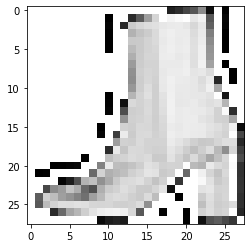

In [15]:
# Load the image
image_pixels = cv2.imread("sample_image.png")
image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_BGR2GRAY)

# Preview the image
plt.imshow(image_pixels, cmap=plt.cm.binary)
plt.show()

In [16]:
# Run inference and parse the prediction
class_probabilities = restored_model.predict(np.expand_dims(image_pixels, 0))[0]
print("Predicted ",CLASSES[np.argmax(class_probabilities)])

Predicted  Ankle boot


We can see that it is working as expected. 

In [0]:
# Load and *preprocess* data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

## Taking it a step further with concrete functions and `SavedModel`

The [`SavedModel`](https://www.tensorflow.org/guide/saved_model) format is the standard serialization format in TensorFlow 2.x since it communicates very well with the entire TensorFlow ecosystem. Be it GCP AI Platform, be it `tf.keras`, be it TFLite, etc,, `SavedModel` format unifies the entire ecosystem. For serializing custom models (developed using [subclassing](https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/)) `SavedModel` would be needed as well. 

In this section, let's see how can we do the same i.e. embed a preprocessing function inside a model so that it can be serialized in the `SavedModel` format. 

### Step 1: Create a sequential model _without_ any preprocessing layer

In [0]:
def get_training_model_v2():
    # Construct the model using the Functional API
    input_layer = tf.keras.layers.Input(shape=(28, 28), name="input_layer")
    flatten = tf.keras.layers.Flatten()(input_layer)
    dense_1 = tf.keras.layers.Dense(128, activation="relu")(flatten)
    dropout = tf.keras.layers.Dropout(0.2)(dense_1)
    outputs = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(dropout)

    # Create the model
    model = tf.keras.models.Model(input_layer, outputs)

    # Compile the model and return it
    model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
        
    return model

### Step 2: Train it!

In [20]:
# Train the model for 10 epochs
apparel_model_v2 = get_training_model_v2()
history = apparel_model_v2.fit(x_train, y_train, 
    validation_data=(x_test, y_test), 
    epochs=10, 
    batch_size=128)

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.5995 - accuracy: 0.7914 - val_loss: 0.4549 - val_accuracy: 0.8347
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4200 - accuracy: 0.8501 - val_loss: 0.4094 - val_accuracy: 0.8520
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3823 - accuracy: 0.8616 - val_loss: 0.3831 - val_accuracy: 0.8635
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3575 - accuracy: 0.8713 - val_loss: 0.3896 - val_accuracy: 0.8563
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3405 - accuracy: 0.8758 - val_loss: 0.3569 - val_accuracy: 0.8720
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3249 - accuracy: 0.8813 - val_loss: 0.3490 - val_accuracy: 0.8733
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3176 - accuracy: 0.8840 - val_loss: 0.3480 - val_accuracy: 0.8735
Epoch 

### Step 3: `SavedModel` plunge

Okay! Now we are ready to the crux of the section. We will first create a custom model class (inherited from `tf.keras.Model`) and it will contain two things:
- A model that is loaded with the weights of a trained model
- A _serving function_ that will contain the preprocessing function along with the necessary signature. 

In [0]:
# A custom class for serving
class ExportModel(tf.keras.Model):
    def __init__(self, model):
        super().__init__(self)
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec([None, 28, 28], dtype=tf.uint8)])
    def my_serve(self, images):
        images = tf.cast(images, tf.float32) / 255        # pre-processing
        probabilities = self.model(images)                # prediction from model
        class_index = tf.argmax(probabilities, axis=-1)   # post-processing
        return {"class_index": class_index}

`my_serve` is our serving function. You can see that is _decorated_ with `tf.function` and the reason behind doing so is it allows us to embed an arbitrary function in a model's graph which can later be exported using the `SavedModel` format. 

We can also see - `input_signature=[tf.TensorSpec([None, 28, 28], dtype=tf.uint8)]`. This is needed in order to indicate which part of the model's graph would be needed while serving. By specifying `tf.TensorSpec([None, 28, 28]`, we instruct the function that the inputs should respect this shape - `[None, 28, 28]` and the `dtype` argument is self-explanatory. 

We will get to why the return type of the function is done in such a way - `{"class_index": class_index}` in a moment.

If you are interested to know more using `SavedModel` and different serialization options that come with it, be sure to check [this tutorial](https://www.tensorflow.org/guide/saved_model) out. 

### Step 4: Instantiate a dummy model and set its weights

In [0]:
# Set the weights of this dummy model to the weights of the model we trained
restored_model = get_training_model_v2()
restored_model.set_weights(apparel_model_v2.get_weights()) 

### Step 5: Export the model and run inference


Now, to serialize the model in the `SavedModel` format we will make use of [`tf.saved_model.save`](https://www.tensorflow.org/api_docs/python/tf/saved_model/save). It can automatically determine which input signature to use for serving for most of the models _if the details are available_. However, in our case, it won't be able to do so. So, we will need to explicitly indicate which function to use as the signature while serving. 

In [23]:
export_path = "/content/saved_model/1/"
tf.keras.backend.set_learning_phase(0) # Make sure no weight update happens
serving_model = ExportModel(restored_model) # Instantiate a model with the preprocessing function
tf.saved_model.save(serving_model, export_path, signatures={'serving_default': serving_model.my_serve})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/saved_model/1/assets


By specifying `'serving_default': serving_model.my_serve` we instructed `tf.saved_model.save` about which signature to use for serving. Now if we inspect what all were saved, things should seem consistent. For this we are going to use the [`saved_model_cli`](https://www.tensorflow.org/guide/saved_model#saved_model_cli) command-line interpreter. 

In [25]:
!saved_model_cli show --dir /content/saved_model/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['images'] tensor_info:
      dtype: DT_UINT8
      shape: (-1, 28, 28)
      name: serving_default_images:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['class_index'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


So, we can see that the configuration that is expected from the inputs and the outputs of the serialized model is consistent with what we had instructed. We returned the outputs in form a dictionary (namely `class_index`) in `my_serve` and we can see that as well. 

We can also do the inspection in Pythonic ways. 

In [24]:
loaded = tf.saved_model.load("/content/saved_model/1/")
print(list(loaded.signatures.keys())) # This signature will be used while serving

['serving_default']


In [26]:
# Output configuration
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'class_index': TensorSpec(shape=(None,), dtype=tf.int64, name='class_index')}


Let's finally run the inference!

In [0]:
# Load the sample image
image_pixels = cv2.imread("sample_image.png")
image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_BGR2GRAY)

In [38]:
# Run inference
CLASSES[infer(tf.constant(image_pixels))["class_index"].numpy()[0]]

'Ankle boot'

We can see that the prediction is correct in this case as well. So, when we ran `infer = loaded.signatures["serving_default"]` we essentially loaded a [concrete function](https://www.tensorflow.org/guide/concrete_function) i.e. we loaded `my_serve`. Remember we assigned the value of `serving_default` in the beginning of this section?

With `infer(tf.constant(image_pixels))` we are simply running our input image through the concrete function and we are parsing the output from the dictionary (`class_index` being the key) it returns . 

## References:
- [MNIST on TPU (Tensor Processing Unit)
or GPU using tf.Keras and tf.data.Dataset](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb)
- [Using the SavedModel format](https://www.tensorflow.org/guide/saved_model#exporting_custom_models)